In [22]:
%matplotlib inline

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from operator import itemgetter

In [2]:

G = nx.Graph()
df_nodes = pd.read_csv('stack_network_nodes.csv')
df_edges = pd.read_csv('stack_network_edges.csv')

In [ ]:
Graphtype = nx.Graph()
G = nx.parse_edgelist(Data, delimiter=',', create_using=Graphtype,
                      nodetype=int, data=(('weight', float),))

In [3]:
for index, row in df_nodes.iterrows():
    G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
    
for index, row in df_edges.iterrows():
    G.add_weighted_edges_from([(row['Source'], row['Target'], row['Weight'])])

for index, row in df_nodes.iterrows():
    G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
    
for index, row in df_edges.iterrows():
    G.add_weighted_edges_from([(row['Source'], row['Target'], row['Weight'])])
    
color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'} 

plt.figure(figsize=(60,40))
options = {
    'edge_color': '#FFDEA2',
    'width': 4,
    'with_labels': True,
}
colors = [color_map[G.node[node]['group']] for node in G]
sizes = [G.node[node]['nodesize']*10 for node in G]

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
default k=0.1 and iterations=50
"""
nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.5, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.show()


In [4]:
def draw_graph(G,size):
    nodes = G.nodes()
    color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'}
    node_color= [color_map[d['group']] for n,d in G.nodes(data=True)]
    node_size = [d['nodesize']*10 for n,d in G.nodes(data=True)]
    pos = nx.drawing.spring_layout(G,k=0.80,iterations=60)
    plt.figure(figsize=size)
    nx.draw_networkx(G,pos=pos,node_color=node_color,node_size=node_size,edge_color='#FFDEA2',edge_width=1)
    plt.show()

/home/rafaila/myvenv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


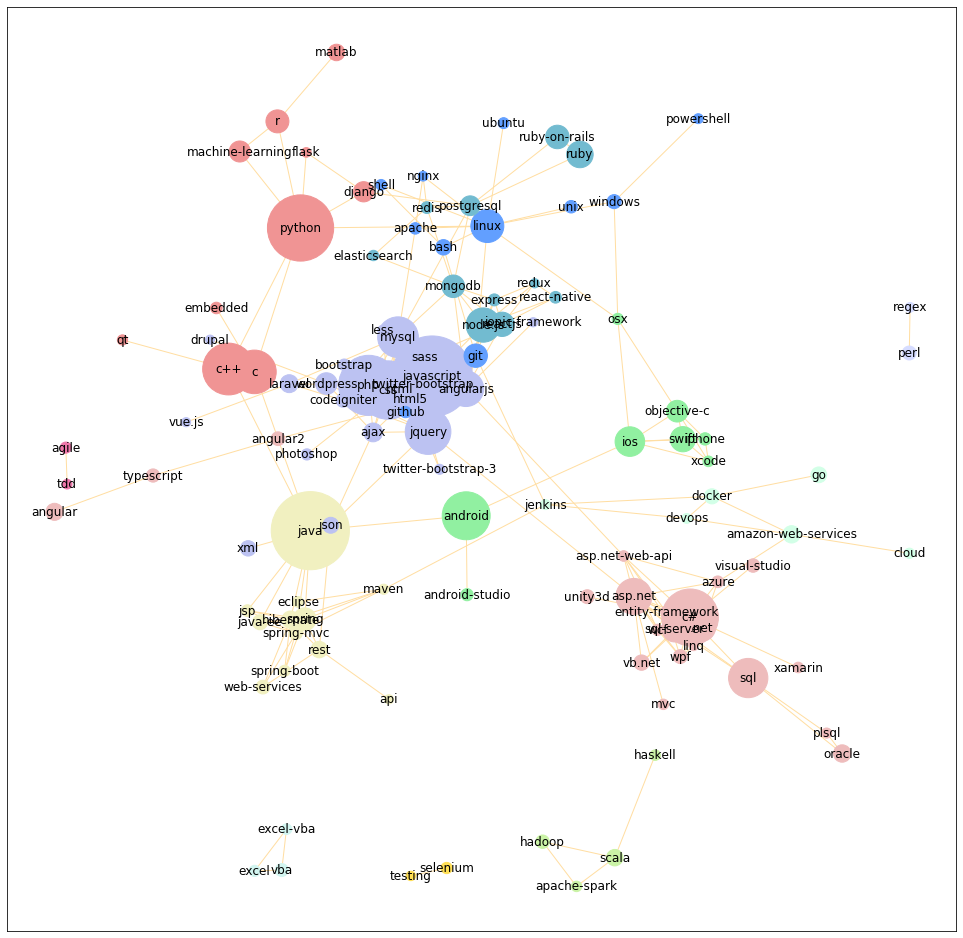

In [5]:
draw_graph(G,size=(17,17))

In [6]:
from networkx.algorithms import community

In [46]:
print(nx.info(G))
for (u, v, d) in G.edges(data=True): print(d['weight'])

Name: 
Type: Graph
Number of nodes: 115
Number of edges: 245
Average degree:   4.2609
126.57112712972766
21.355688890230827
59.75548884052987
45.66104087971068
23.639529235488702
44.233620230219444
26.61371372468893
22.210413043130053
24.71031260188158
27.010622489444646
20.85572142496804
66.67420569975171
75.53660009612221
87.13826986156899
31.56405510257182
25.340535324481124
31.264824668848835
40.963361265498364
51.44760490910893
39.4069459855106
32.523565104522916
30.23290370637627
34.10005202479125
21.646667877763228
21.210956925188103
64.10989821309226
39.90817378554485
103.26828446355265
43.95425922531434
39.81210514851685
30.61333985121873
39.53022984092444
26.117598626312642
20.16560629687762
63.33021731315285
57.04039265671136
21.79517505760149
95.3613107122033
25.690110329072738
39.778036225705506
87.21964246099866
30.34158107188327
78.75928046651394
57.15857405623157
46.36509077387072
36.02337467321895
79.0885357791676
48.62033486702057
23.08266402075043
32.350506919162136


## Network Metrics

### Density

In [19]:
density = nx.density(G)
print("Network density: %4f" % density)


Network density: 0.037376


On a scale of 0 to 1, not a very dense network, which comports with what you saw in the visualization. A 0 would mean that there are no connections at all, and a 1 would indicate that all possible edges are present (a perfectly connected network): this network is on the lower end of that scale, but still far from 0.

### Shortest Path

It calculates the shortest possible series of nodes and edges that stand between any two nodes, something hard to see in large network visualizations. This measure is essentially finding friends-of-friends—if tag x is connected with y and w is connected with y, but not with x, then the shortest path between x and w is y. The Six Degrees of Kevin Bacon game, from which our project takes its name, is basically a game of finding shortest paths (with a path length of six or less) from Kevin Bacon to any other actor.

To calculate a shortest path, you’ll need to pass several input variables (information you give to a Python function): the whole graph, your source node, and your target node. Let’s find the shortest path between javascript and linux. 

In [9]:
fell_wh = nx.shortest_path(G, source="javascript", target="linux")

print("Shortest path between javascript and linux:", fell_wh, "and the length of that path is", len(fell_wh)-1)

Shortest path between javascript and linux: ['javascript', 'mysql', 'apache', 'linux'] and the length of that path is 3


Since there is no shortest path between nodes of one component and nodes of another, nx.diameter() returns the “not connected” error. You can remedy this by first finding out if your Graph “is connected” (i.e. all one component) and, if not connected, finding the largest component and calculating diameter on that component alone. Here’s the code:

In [50]:
print(nx.is_connected(G))

False


In [11]:
# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)


Network diameter of largest component: 10


The network diameter of this network’s largest component is 10: there is a path length of 10 between the two farthest-apart nodes in the network. Unlike density which is scaled from 0 to 1, it is difficult to know from this number alone whether 10 is a large or small diameter. 

Triadic closure supposes that if two people know the same person, they are likely to know each other. If x is connected with both y and w, then y and w may very well know each other, completing a triangle in the visualization of three edges connecting x, y, and w. The number of these enclosed triangles in the network can be used to find clusters and communities of individuals that all know each other fairly well.
One way to measure triadic closure is called clustering coefficient because of this clustering tendency, but it is also known as transitivity.Transitivity is the ratio of all triangles over all possible triangles. A possible triangle exists when one tag x knows two others (y and w). So transitivity, like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. Remember, measurements like transitivity and density concern likelihoods rather than certainties. Transitivity allows you a way of thinking about all the relationships in your graph that may exist but currently do not.

In [18]:
triadic_closure = nx.transitivity(G)
print("Triadic closure=%4f" % triadic_closure)

Triadic closure=0.487092


Also like density, transitivity is scaled from 0 to 1, and you can see that the network’s transitivity is about 0.487092, somewhat higher than its 0.037376 density. Because the graph is not very dense, there are fewer possible triangles to begin with, which may result in slightly higher transitivity. That is, nodes that already have lots of connections are likely to be part of these enclosed triangles. 

In [25]:
triangles = nx.triangles(G)
print(triangles)

{'html': 13, 'css': 36, 'hibernate': 16, 'spring': 16, 'ruby': 1, 'ruby-on-rails': 1, 'ios': 7, 'swift': 6, 'html5': 24, 'c': 2, 'c++': 2, 'asp.net': 31, 'c#': 31, 'objective-c': 7, 'javascript': 34, 'jquery': 40, 'redux': 5, 'reactjs': 14, 'php': 26, 'mysql': 20, 'spring-mvc': 13, '.net': 22, 'react-native': 3, 'spring-boot': 3, 'less': 3, 'sass': 22, 'hadoop': 1, 'apache-spark': 1, 'sql-server': 23, 'express': 8, 'node.js': 12, 'mongodb': 9, 'iphone': 6, 'github': 0, 'git': 1, 'excel': 1, 'excel-vba': 1, 'entity-framework': 24, 'linq': 20, 'wcf': 24, 'wpf': 15, 'android': 0, 'java': 10, 'scala': 1, 'ajax': 14, 'django': 1, 'python': 3, 'vba': 1, 'xcode': 6, 'apache': 1, 'nginx': 1, 'angularjs': 24, 'asp.net-web-api': 12, 'laravel': 3, 'plsql': 1, 'oracle': 1, 'json': 1, 'xml': 0, 'flask': 1, 'wordpress': 8, 'java-ee': 6, 'maven': 3, 'jsp': 6, 'bash': 2, 'linux': 4, 'angular2': 0, 'typescript': 0, 'codeigniter': 10, 'tdd': 0, 'agile': 0, 'twitter-bootstrap': 15, 'web-services': 3, 're

In [32]:
print ("The total triangles of this network is %d." % (sum(triangles.values())/3))

The total triangles of this network is 239.


Text(0.5, 1.0, 'Stack Overflow Tag Degree Distribution')

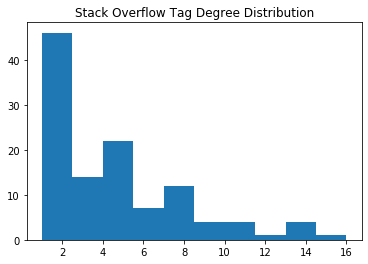

In [68]:
plt.hist([node[1] for node in list(G.degree())])
plt.title("Stack Overflow Tag Degree Distribution")



### Centrality

In network analysis, measures of the importance of nodes are referred to as centrality measures. Because there are many ways of approaching the question “Which nodes are the most important?” there are many different ways of calculating centrality. Here you’ll learn about three of the most common centrality measures: degree, betweenness centrality, and eigenvector centrality.

Degree is the simplest and the most common way of finding important nodes. A node’s degree is the sum of its edges. If a node has three lines extending from it to other nodes, its degree is three. Five edges, its degree is five. It’s really that simple. Since each of those edges will always have a node on the other end, you might think of degree as the number of people to which a given person is directly connected. The nodes with the highest degree in a social network are the people who know the most people. These nodes are often referred to as hubs, and calculating degree is the quickest way of identifying hubs.

In [13]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [20]:
print(G.nodes['javascript'])

{'group': 6, 'nodesize': 649.16, 'degree': 12}


In [23]:
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [24]:
print("Top 20 nodes by degree:")
for d in sorted_degree[:20]:
    print(d)


Top 20 nodes by degree:
('jquery', 16)
('css', 14)
('c#', 14)
('asp.net', 13)
('angularjs', 13)
('javascript', 12)
('mysql', 11)
('html5', 10)
('php', 10)
('linux', 10)
('hibernate', 9)
('spring', 9)
('sass', 9)
('sql-server', 9)
('reactjs', 8)
('.net', 8)
('mongodb', 8)
('entity-framework', 8)
('wcf', 8)
('java', 8)


In [54]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality

# Assign each to an attribute in your network
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')


In [55]:
sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by betweenness centrality:")
for b in sorted_betweenness[:20]:
    print(b)


Top 20 nodes by betweenness centrality:
('jquery', 0.2555399753457234)
('linux', 0.20840160874161803)
('mysql', 0.1976931477327379)
('asp.net', 0.17406690608353667)
('apache', 0.13087186063431988)
('json', 0.12319763505138448)
('angularjs', 0.12286762799187795)
('rest', 0.11370118004957315)
('python', 0.11018306022497917)
('postgresql', 0.08761830339613291)
('java', 0.07601405167311084)
('mongodb', 0.06737252741910403)
('osx', 0.06635551651853466)
('jenkins', 0.05981851611101727)
('django', 0.05779082240190766)
('amazon-web-services', 0.056437373973470865)
('c#', 0.055756579881898374)
('azure', 0.05400019656985602)
('asp.net-web-api', 0.053419633104008046)
('hibernate', 0.053043904033657156)


In [65]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 nodes by eigenvector centrality:")
for b in sorted_eigenvector[:20]:
    print(b)


Top 20 nodes by eigenvector centrality:
('jquery', 0.3657638453622554)
('css', 0.338701180241117)
('javascript', 0.32563098638889276)
('html5', 0.2681052746250041)
('php', 0.26530101525817973)
('angularjs', 0.2652026528173442)
('sass', 0.2520957761852705)
('mysql', 0.239342658253863)
('twitter-bootstrap', 0.20709455337131874)
('html', 0.2038246927757326)
('ajax', 0.19962166194538747)
('wordpress', 0.16028159729147778)
('codeigniter', 0.14895861770584937)
('reactjs', 0.13770631051407162)
('asp.net', 0.1133542478710743)
('node.js', 0.11189410352446867)
('mongodb', 0.1032689802929971)
('less', 0.09797510969685971)
('bootstrap', 0.08035855855730212)
('asp.net-web-api', 0.07857086259618636)


 ## Bridges

A bridge is a connection between two nodes that if it were to be deleted it would cause the total division of th main component into two separate components.

In [34]:
nx.has_bridges(G)

True

In [36]:
list(nx.bridges(G))

[('css', 'photoshop'),
 ('c', 'embedded'),
 ('c++', 'qt'),
 ('asp.net', 'mvc'),
 ('c#', 'xamarin'),
 ('c#', 'unity3d'),
 ('c#', 'visual-studio'),
 ('github', 'git'),
 ('android', 'android-studio'),
 ('scala', 'haskell'),
 ('angularjs', 'angular2'),
 ('angularjs', 'ionic-framework'),
 ('laravel', 'vue.js'),
 ('json', 'xml'),
 ('wordpress', 'drupal'),
 ('maven', 'eclipse'),
 ('linux', 'unix'),
 ('linux', 'ubuntu'),
 ('angular2', 'typescript'),
 ('typescript', 'angular'),
 ('tdd', 'agile'),
 ('rest', 'api'),
 ('testing', 'selenium'),
 ('docker', 'go'),
 ('amazon-web-services', 'cloud'),
 ('windows', 'powershell'),
 ('r', 'matlab'),
 ('regex', 'perl')]

In [37]:
list(nx.local_bridges(G))

[('css', 'photoshop', inf),
 ('ios', 'android', 6),
 ('c', 'embedded', inf),
 ('c++', 'qt', inf),
 ('asp.net', 'jquery', 3),
 ('asp.net', 'mvc', inf),
 ('c#', 'xamarin', inf),
 ('c#', 'unity3d', inf),
 ('c#', 'visual-studio', inf),
 ('mysql', 'apache', 4),
 ('github', 'git', inf),
 ('git', 'jenkins', 7),
 ('android', 'android-studio', inf),
 ('android', 'java', 6),
 ('scala', 'haskell', inf),
 ('django', 'postgresql', 5),
 ('python', 'linux', 5),
 ('nginx', 'redis', 4),
 ('angularjs', 'angular2', inf),
 ('angularjs', 'ionic-framework', inf),
 ('angularjs', 'asp.net-web-api', 3),
 ('laravel', 'vue.js', inf),
 ('json', 'rest', 9),
 ('json', 'xml', inf),
 ('wordpress', 'drupal', inf),
 ('maven', 'eclipse', inf),
 ('maven', 'jenkins', 7),
 ('linux', 'unix', inf),
 ('linux', 'ubuntu', inf),
 ('angular2', 'typescript', inf),
 ('typescript', 'angular', inf),
 ('tdd', 'agile', inf),
 ('rest', 'api', inf),
 ('testing', 'selenium', inf),
 ('docker', 'go', inf),
 ('amazon-web-services', 'cloud', 

In [38]:
r=nx.degree_assortativity_coefficient(G)
print("%.4f" % r)

0.1889


## Community

In [51]:
communities = community.greedy_modularity_communities(G)


In [52]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')


In [56]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]

# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}

# Then sort that dictionary and print the first 5 results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)

print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector[:5]:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])


Modularity Class 0 Sorted by Eigenvector Centrality:
Name: jquery | Eigenvector Centrality: 0.3657638453622554
Name: css | Eigenvector Centrality: 0.338701180241117
Name: javascript | Eigenvector Centrality: 0.32563098638889276
Name: html5 | Eigenvector Centrality: 0.2681052746250041
Name: php | Eigenvector Centrality: 0.26530101525817973


In [57]:
for i,c in enumerate(communities): # Loop through the list of communities
    if len(c) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(i)+':', list(c)) # Print out the classes and their members

Class 0: ['bootstrap', 'java', 'asp.net-web-api', 'cloud', 'plsql', 'typescript', 'sass', 'entity-framework', 'flask', 'twitter-bootstrap', 'ruby', 'bash', 'django', 'git', 'mongodb', 'docker', 'sql', 'asp.net', 'machine-learning', 'c#', 'c', 'rest', 'qt', 'php', 'matlab', 'mysql', 'ruby-on-rails', 'html5', 'swift', 'angularjs', 'vb.net', 'sql-server', 'express', 'mvc', 'redis', 'r', 'twitter-bootstrap-3', 'objective-c', 'xamarin', 'redux', 'maven', 'hibernate', 'unity3d', 'api', 'apache', 'nginx', 'amazon-web-services', 'ubuntu', 'wordpress', '.net', 'web-services', 'spring', 'embedded', 'ajax', 'visual-studio', 'android-studio', 'ionic-framework', 'node.js', 'javascript', 'wcf', 'go', 'shell', 'devops', 'photoshop', 'android', 'laravel', 'github', 'reactjs', 'elasticsearch', 'eclipse', 'css', 'windows', 'osx', 'less', 'iphone', 'vue.js', 'linux', 'java-ee', 'postgresql', 'angular', 'html', 'wpf', 'angular2', 'python', 'spring-boot', 'jsp', 'jenkins', 'react-native', 'json', 'unix', '

In [59]:
pr = nx.pagerank(G, alpha=0.9)
pr

{'html': 0.012594662978428865,
 'css': 0.02635660329861141,
 'hibernate': 0.019954696359007727,
 'spring': 0.021838890237060652,
 'ruby': 0.007604385617820876,
 'ruby-on-rails': 0.007832717128817482,
 'ios': 0.016380082909881504,
 'swift': 0.011679028663927936,
 'html5': 0.014670514634657201,
 'c': 0.011737502898462086,
 'c++': 0.0118328265860184,
 'asp.net': 0.023191718246589534,
 'c#': 0.0240397726574954,
 'objective-c': 0.01303183991198786,
 'javascript': 0.019421962751447436,
 'jquery': 0.02416064028032634,
 'redux': 0.006260253062635457,
 'reactjs': 0.014016437822306537,
 'php': 0.01811051280111034,
 'mysql': 0.014344505138086201,
 'spring-mvc': 0.014858226055849442,
 '.net': 0.012318794256533885,
 'react-native': 0.005168336782966781,
 'spring-boot': 0.007714544800421996,
 'less': 0.004782353381748496,
 'sass': 0.011121289195221856,
 'hadoop': 0.008879069604642988,
 'apache-spark': 0.011921648839380098,
 'sql-server': 0.013372028707963156,
 'express': 0.008401867892802686,
 'node

## Cliques

In [60]:
cliques = list(nx.find_cliques(G))


In [61]:
clique_number = len(list(cliques))
print(clique_number)



89


In [62]:
for clique in cliques:
    print(clique)

['java', 'c', 'c++']
['java', 'hibernate', 'spring-mvc', 'spring', 'jsp']
['java', 'hibernate', 'spring-mvc', 'spring', 'java-ee']
['java', 'android']
['apache', 'nginx', 'linux']
['apache', 'mysql']
['nginx', 'redis']
['amazon-web-services', 'devops', 'docker']
['amazon-web-services', 'azure']
['amazon-web-services', 'cloud']
['ubuntu', 'linux']
['asp.net-web-api', 'angularjs']
['asp.net-web-api', 'asp.net', 'c#', 'entity-framework', 'wcf', 'sql-server']
['asp.net-web-api', 'asp.net', 'c#', 'azure']
['.net', 'asp.net', 'c#', 'wcf', 'linq', 'entity-framework', 'wpf']
['.net', 'asp.net', 'c#', 'wcf', 'linq', 'entity-framework', 'sql-server']
['.net', 'asp.net', 'c#', 'azure']
['web-services', 'rest', 'hibernate', 'spring']
['spring', 'hibernate', 'spring-mvc', 'maven']
['spring', 'hibernate', 'spring-mvc', 'spring-boot']
['embedded', 'c']
['visual-studio', 'c#']
['excel', 'excel-vba', 'vba']
['android-studio', 'android']
['ionic-framework', 'angularjs']
['node.js', 'reactjs', 'express',

## Language Specific Ego Network And Cliques

For each programming language there's a tag in the network. E.g 'python' will refer to the python language. So we can check the cliques that contains that node. We can also visualize the ego network for a node. Ego network for a node is the subgraph containing that node and all its neighbors with a specifed depth range.

For example, we can check the ego network for python with radius 2, which means that we get the subgraph containing python and all it's direct neighbors which are 1 edge away from python and also the nodes which are 2 hop away from python.

Ego networks can be used for checking shortest paths or generally conducting analysis of who is connected to whom, but cliques are helpful because it shows us the data in a more granular way.


In [69]:
print(nx.ego_graph(G,'java',radius=2).nodes())

['c', 'ios', 'qt', 'hibernate', 'maven', 'android', 'rest', 'jsp', 'java', 'java-ee', 'embedded', 'c++', 'spring', 'spring-mvc', 'python', 'web-services', 'android-studio', 'spring-boot']


In [70]:
nx.algorithms.clique.cliques_containing_node(G,"java")



[['java', 'c', 'c++'],
 ['java', 'hibernate', 'spring-mvc', 'spring', 'jsp'],
 ['java', 'hibernate', 'spring-mvc', 'spring', 'java-ee'],
 ['java', 'android']]

In [71]:
nx.algorithms.clique.cliques_containing_node(G,"python")



[['flask', 'django', 'python'],
 ['machine-learning', 'r', 'python'],
 ['c', 'python', 'c++'],
 ['linux', 'python']]

In [72]:
nx.algorithms.clique.cliques_containing_node(G,"c++")



[['java', 'c', 'c++'], ['c', 'python', 'c++'], ['qt', 'c++']]

In [73]:
sorted_cliques = sorted(list(nx.find_cliques(G)),key=len)

In [74]:
max_clique_nodes = set()

for nodelist in sorted_cliques[-4:-1]:
    for node in nodelist:
        max_clique_nodes.add(node)



In [75]:
max_clique = G.subgraph(max_clique_nodes)


In [76]:
print(nx.info(max_clique))



Name: 
Type: Graph
Number of nodes: 14
Number of edges: 43
Average degree:   6.1429


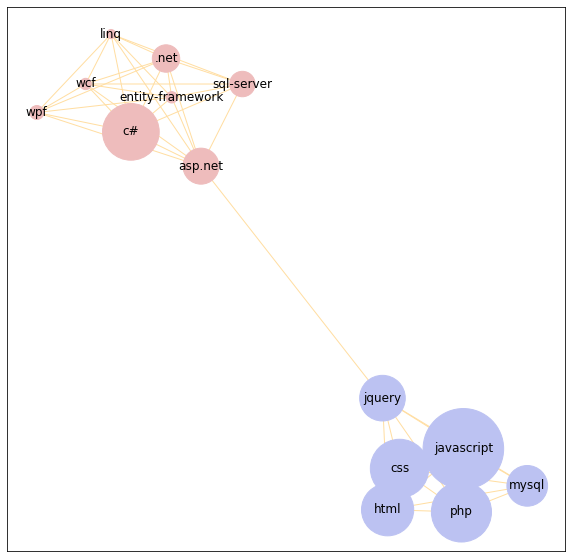

In [77]:
draw_graph(max_clique,size=(10,10))

## Trends in Stack Overflow

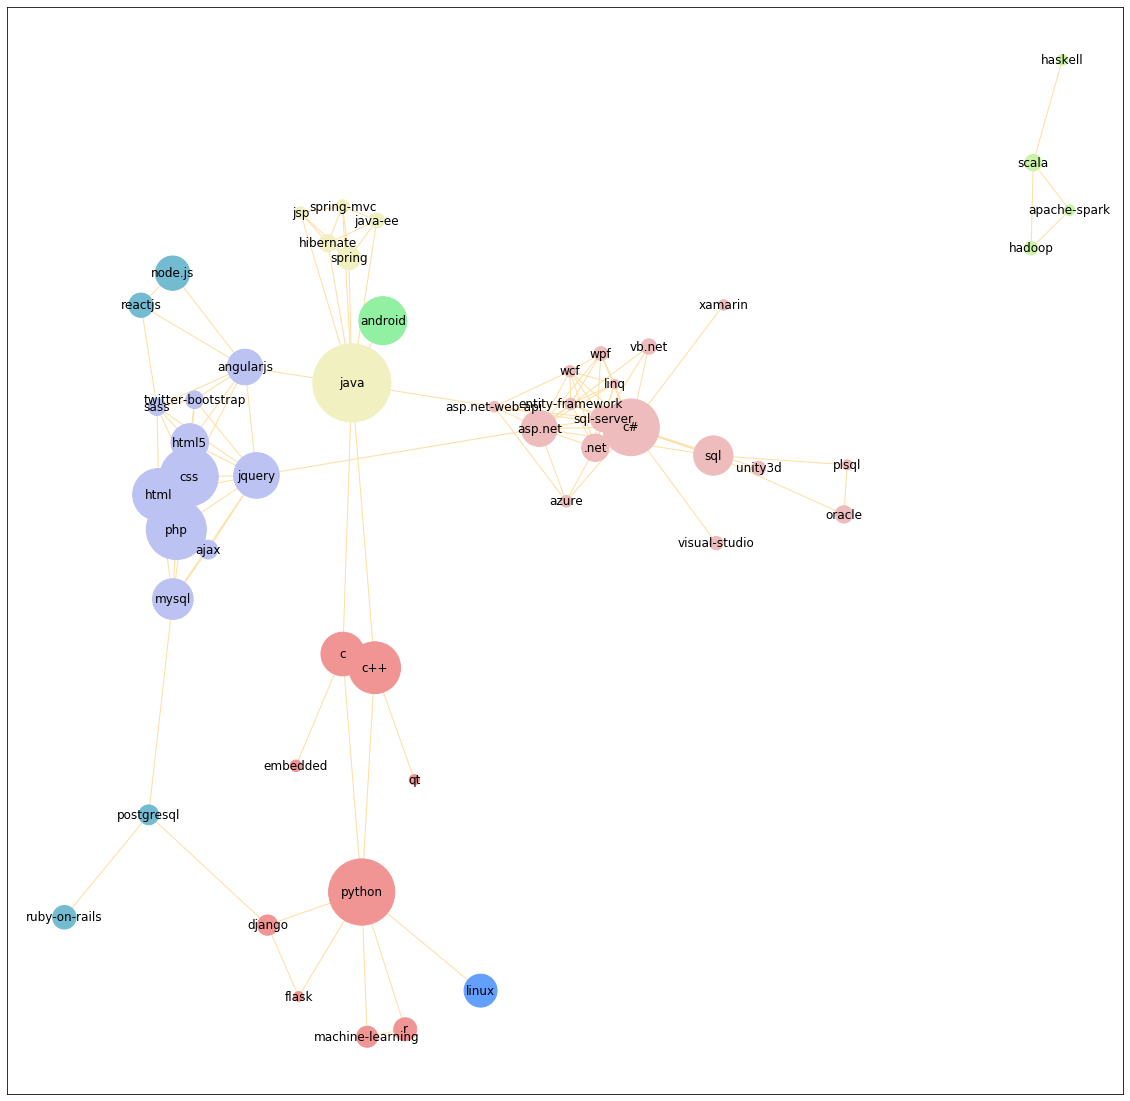

In [78]:
major_languages = ['c','c++','c#','java','python','ruby','scala','haskell','javascript','sql']

p_language_nodes = []
for language in major_languages:
    neighbors = G.neighbors(language)
    p_language_nodes.extend(neighbors)

programming_language_graph = G.subgraph(set(p_language_nodes))

draw_graph(programming_language_graph,size=(20,20))

